In [1]:
import functools
import ast

import numpy as np
import pandas as pd

import numpy_financial as npf

from ipywidgets import (interact, interactive, fixed, interact_manual,
                        FloatSlider, FloatLogSlider, IntSlider, HTML,
                        AppLayout, VBox, HBox, Dropdown, Label)

from utils import get_sheet, clean_string, default_params

# Pulling data from the original spreadsheet

In [2]:
sheets = {
    'natural_gas': get_sheet('C1 - Natural Gas'),
    'report_data': get_sheet('Report Data'),
    'economic_parameters': get_sheet('Economic Parameters'),
    'eai_data': get_sheet('EIA Data Annual Energy Outlook'),
    'case_summary': get_sheet('Case Summary with Embodied')
}


conversions = {
    'mmBTU/GJ': sheets['natural_gas']['H48'],
    'kg/lbs': sheets['natural_gas']['H49']
}

,scenario,Low,High
0,1,225.84,395
1,2A,470.00,658
2,2B,495.00,685
3,2C,493.00,890
4,3A,399.00,562


Text(0, 0.5, 'Cost [$/tCO2]')

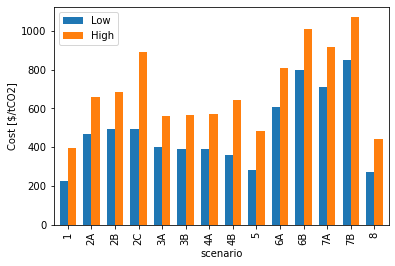

In [3]:
# open the sheet

# pull a table into a Pandas DataFrame
df = sheets['case_summary']['B7:Q20']

# a bit of munging...
df = df[[1, 2, 3]]
df.columns = ['scenario', 'Low', 'High']
# strings -> floats
df = df.apply(clean_string)

# show the first few rows
display(df.head())

# make a quick bar plot
ax = df.set_index('scenario').plot.bar(width=.7)
ax.set_ylabel('Cost [$/tCO2]')

# Working backwards

Goal: start with a single value in the spreadsheet that we'd like the API to calculate. Trace its algorithmic path, using data from the spreadhseet when necessary to gradually develop the API.

### Collect model parameters

In [4]:
def get_eia_data():
    eai_df = sheets['eai_data']['B4:I17']
    header = eai_df.iloc[0]
    eai_df = eai_df[1:].rename(columns=header).set_index('').apply(clean_string)
    eai_df = eai_df.apply(pd.to_numeric, errors='coerce')

    # add availability
    avail = sheets['eai_data']['C27:I27']
    avail.index = ['Availability'] 
    avail = avail.rename(columns=header[1:].reset_index(drop=True))
    eai_df = eai_df.append(avail.apply(clean_string) / 100.)
    
    return eai_df
    
eai_df = get_eia_data()
eai_df

,Wind,Advanced NGCC,NGCC w/ CCS,Advanced Nuclear,Solar,Battery Storage,Geothermal EIA 2020
Overnight Cost [$/kW],1319.00,954.0000,2569.0000,6317.00,1331.000,1383.00,2680.00
Plant Size [MW],200.00,1083.0000,377.0000,2156.00,150.000,50.00,50.00
Base Plant Cost [M$],263.80,1033.2000,968.5000,13619.50,199.700,69.20,134.00
Battery Capacity [MWhr],NaN,NaN,NaN,NaN,NaN,200.00,NaN
Lead Time [Years],3.00,3.0000,3.0000,6.00,2.000,1.00,4.00
Variable O&M [$/MWhr],0.00,1.8600,5.8200,2.36,0.000,0.00,1.16
Fixed O&M [$/kW-yr],26.22,12.1500,27.4800,121.13,15.190,24.70,113.29
Base Plant Annual Fixed O&M [$M],5.24,13.1600,10.3600,261.16,2.280,1.24,5.66
Final Heat Rate [BTU/kWh],NaN,6370.0000,7124.0000,10461.00,NaN,NaN,9156.00
Capacity Factor,43.00,87.0000,87.0000,90.00,31.000,NaN,NaN


In [5]:
params = default_params(sheets, 'low')
params

{'scale': 1000000,
 'dac_capacity_factor': 0.9,
 'lead_time': 3,
 'overnight_capex': 1029,
 'low_value_case': 46.6,
 'thermal_requirement': 6.64,
 'fixed_o_m_cost': 34,
 'variable_o_m_cost': 4,
 'lifetime': 20,
 'wacc': 0.085,
 'ng_cost': 3.43,
 'natural_gas_energy_scaling_factor': 0.7,
 'npv': 1}

In [6]:
# Project Lead Time Escalation of Overnight EPC Costs
def calc_lead_time_mult(rate, time):
    '''replaces cells =Q5:AB158 in `WACC Table Project Lead Time`'''
    vals = np.zeros(time)
    vals[0] = (1+rate)*(1/time)
    # there is almost certainly a better way to express this
    for t in range(1, time):
        vals[t] = np.sum(vals[:t]) * rate + (1+rate)*(1/time)
    return vals.sum()

In [10]:
def electricity_requirements(params, scenario='NGCC w/ CCS'):
    
    # Planned Capacity Factor
    # Parameter: ='EIA Data Annual Energy Outlook'!E27
    planned_capacity_factor = eai_df.loc['Availability', scenario]

    # Low Value  Case [MW]
    # Equation: =C18
    # Equation: ='Report Data'!C58
    low_value_case = params['low_value_case']

    # Plant Size [MW]
    # =K15/K14
    plant_size = low_value_case / planned_capacity_factor
    
    # Overnight Cost [M$]
    # Equation:='EIA Data Annual Energy Outlook'!E7*('C1 - Natural Gas'!K16/'EIA Data Annual Energy Outlook'!E6)^'Economic Parameters'!F5
    overnight_cost = eai_df.loc['Base Plant Cost [M$]', scenario] * (plant_size / eai_df.loc['Plant Size [MW]', scenario])**params['natural_gas_energy_scaling_factor']
    
    # Lead Time Multiplier
    # Equation: =VLOOKUP('Economic Parameters'!$C$5,'WACC Table Project Lead Time'!$Q$12:$W$33, MATCH('EIA Data Annual Energy Outlook'!$E$9,'WACC Table Project Lead Time'!$Q$12:$W$12,0), FALSE)
    lead_time_mult = calc_lead_time_mult(params['wacc'], params['lead_time'])  # Note: this leads to rounding differences that are non-trivial   

    # Capital Cost [M$] 
    # Equation: =K17*K18
    # Total Capital Cost [M$]
    # Equation: =K19
    capital_cost = overnight_cost * lead_time_mult
    
    # Annual Capital Recovery Factor
    # Equation: =VLOOKUP(C5,'WACC Table Project Lead Time'!C8:M50, MATCH(C4,'WACC Table Project Lead Time'!C9:M9,0), FALSE)
    recovery_factor = -npf.pmt(params['wacc'], params['lifetime'], params['npv'])
    
    # Capital Recovery [$/tCO2eq]
    # Equation: =K20*'Economic Parameters'!C6*10^6/'Report Data'!C3
    capital_recovery_cost = capital_cost * recovery_factor * 1e6 / params['scale']
    
    # Power Fixed O&M [$/tCO2eq]
    # Equation: =('EIA Data Annual Energy Outlook'!E12*('C1 - Natural Gas'!K16/'EIA Data Annual Energy Outlook'!E6)^'Economic Parameters'!F5)*10^6/'Report Data'!C3
    power_fixed_o_m_cost = (eai_df.loc['Base Plant Annual Fixed O&M [$M]', scenario] * (plant_size / eai_df.loc['Plant Size [MW]', scenario]) ** params['natural_gas_energy_scaling_factor']) * 1e6 / params['scale']

    # Operational Hours [h/yr]
    # Equation: !Report Data =365*24*C4
    operational_hours = params['dac_capacity_factor'] * 365 * 24
    
    # Total Fixed O&M [$/tCO2eq]
    # Total Variable O&M [$/tCO2eq]
    # Equation: =K23
    # This points to Power Variable O&M
    # Power Variable O&M [$/tCO2eq]
    # Equation: ='EIA Data Annual Energy Outlook'!E10*K16*'Report Data'!C5/'Report Data'!C3
    variable_o_m_cost = eai_df.loc['Variable O&M [$/MWhr]', 'NGCC w/ CCS'] * plant_size * operational_hours / params['scale']
   
    # Natural Gas Use [mmBTU/tCO2eq]
    # Equation: ='Report Data'!C5*K16*1000*'EIA Data Annual Energy Outlook'!E13/10^6/'Report Data'!C3
    natural_gas_use = operational_hours * plant_size * 1000 * eai_df.loc['Final Heat Rate [BTU/kWh]', scenario] / 1e6 / params['scale']
    
    # Natural Gas Cost [$/tCO2eq]
    # Equation: =K26*F17
    natural_gas_cost = natural_gas_use * params['ng_cost']
    
    # Emitted tCO2eq/tCO2 
    
    return {
        'natural_gas_cost': natural_gas_cost,
        'variable_o_m_cost': variable_o_m_cost,
        'power_fixed_o_m_cost': power_fixed_o_m_cost,
        'capital_recovery_cost': capital_recovery_cost,
    }


def nas_report_table_511(params):
    # Capacity [MtCO2/yr]
    capacity = 1.
    
    # Required Thermal Energy [GJ/tCO2]
    # Parameter: =+'Report Data'!E67
    req_thermal_energy_gj = params['thermal_requirement']
    # Thermal [GJ]
    # Required Thermal Energy [mmBTU/tCO2]
    # Equation: =C84*$H$48
    req_thermal_energy_mmbtu = req_thermal_energy_gj * conversions['mmBTU/GJ']
    
    # Natural Gas [mmBTU]
    # Equation: =C86*'Report Data'!C3
    natural_gas = req_thermal_energy_mmbtu * params['scale']
    
    # Emissions [tCO2/year]
    # Flue Gas Capture Power [MWh/tCO2]
    # Necessary Power [MWh]
    # Power Plant Requirements [MW]
    return {
        'capacity': capacity,
        'natural_gas': natural_gas
    }


def thermal_requirements(params, scenario='Advanced NGCC'):
    
    nas_511 = nas_report_table_511(params)
    
    # Planned Capacity Factor
    # Parameter: ='EIA Data Annual Energy Outlook'!D27
    planned_capacity_factor = eai_df.loc['Availability', scenario]

    # Low Value Case [MW]
    # Hardcoded
    low_value_case = 0.

    # Plant Size [MW]
    # Equation: =K31/K30
    plant_size = low_value_case / planned_capacity_factor

    # Overnight Cost [M$]
    # Equation: ='EIA Data Annual Energy Outlook'!C7*('C1 - Natural Gas'!K32/'EIA Data Annual Energy Outlook'!C6)^'Economic Parameters'!F5
    # JH Q: why is this wind?
#     overnight_cost = eai_df.loc['Base Plant Cost [M$]', 'Wind'] * (plant_size / eai_df.loc['Plant Size [MW]', 'Wind'])**sheets['economic_parameters']['F5']
    overnight_cost = eai_df.loc['Base Plant Cost [M$]', scenario] * (plant_size / eai_df.loc['Plant Size [MW]', scenario])**sheets['economic_parameters']['F5']
   
    # Lead Time Multiplier
    # Equation: =VLOOKUP('Economic Parameters'!$C$5,'WACC Table Project Lead Time'!$Q$12:$W$33, MATCH('EIA Data Annual Energy Outlook'!$D$9,'WACC Table Project Lead Time'!$Q$12:$W$12,0), FALSE)
    lead_time_mult = calc_lead_time_mult(params['wacc'], params['lead_time'])  # Note: this leads to rounding differences that are non-trivial
    
    # Capital Cost [M$] 
    # Equation: =K33*K34
    # Total Capital Cost [M$]
    # Equation: =K35
    capital_cost = overnight_cost * lead_time_mult
    
    # Annual Capital Recovery Factor
    # Equation: =VLOOKUP(C5,'WACC Table Project Lead Time'!C8:M50, MATCH(C4,'WACC Table Project Lead Time'!C9:M9,0), FALSE)
    recovery_factor = -npf.pmt(params['wacc'], params['lifetime'], params['npv'])
    
    # Capital Recovery [$/tCO2eq]
    # Equation: =K36*'Economic Parameters'!C6
    capital_recovery_cost = capital_cost * recovery_factor
    
    # Power Fixed O&M [$/tCO2eq]
    # Equation: =K32*'EIA Data Annual Energy Outlook'!D11*1000/10^6
    power_fixed_o_m_cost = plant_size * eai_df.loc['Fixed O&M [$/kW-yr]', scenario] * 1000/1e6
    
    # Total Fixed O&M [$/tCO2eq]
    # not used yet

    # Operational Hours [h/yr]
    # Equation: !Report Data =365*24*C4
    operational_hours = params['dac_capacity_factor'] * 365 * 24
    
    # Total Variable O&M [$/tCO2eq]
    # Equation: =K23
    # This points to Power Variable O&M
    # Power Variable O&M [$/tCO2eq]
    # Equation: =K32*'EIA Data Annual Energy Outlook'!D10*( 'Report Data'!C5)/'Report Data'!C3
    variable_o_m_cost = plant_size * eai_df.loc['Variable O&M [$/MWhr]', scenario] * operational_hours / params['scale']

    # Natural Gas Use [mmBTU/tCO2eq]
    # Equation: =+C87/(C82*1000000)
    natural_gas_use = nas_511['natural_gas'] / (nas_511['capacity'] * 1000000)
    
    # Natural Gas Cost [$/tCO2eq]
    # Equation: =K42*F17
    natural_gas_cost = natural_gas_use * params['ng_cost']

    # tCO2/tCO2from air
    
    return {
        'natural_gas_cost': natural_gas_cost,
        'variable_o_m_cost': variable_o_m_cost,
        'power_fixed_o_m_cost': power_fixed_o_m_cost,
        'capital_recovery_cost': capital_recovery_cost,
    }


def incremental_flue_gas_costs(params):
    # JH: all are zero in spreadhseet
    
    # Overnight Capital Cost [M$]
    # Lead Time multiplier
    # Capital Cost (including Lead Time) [M$]
    # Capital Recovery [$/tCO2eq]
    # Fixed Cost [$/tCO2]
    # Variable Cost [$/tCO2]
    # Extra Natural Gas Cost [$/tCO2]
    # tCO2eq/tCO2
    
    return {
        'variable_o_m_cost': 0.,
        'fixed_cost': 0.,
        'capital_recovery_cost': 0.,
    }

# ----------------- Overall Costs ----------------- #
# ---------------- Utility Section ---------------- #
def utility_costs(params):
    
    # from above: 
    electric = electricity_requirements(params)
    thermal = thermal_requirements(params)
    incremental_flue = incremental_flue_gas_costs(params)
    
    # Total Power Capacity Required (MW)
    # not used yet
    
    # Total Capital Cost [M$]
    # not used yet

    # Capital Recovery [$/tCO2eq]
    # Equation: =SUM('C1 - Natural Gas'!K21,'C1 - Natural Gas'!K37,'C1 - Natural Gas'!K49)
    capital_recovery_cost = electric['capital_recovery_cost'] + thermal['capital_recovery_cost'] + incremental_flue['capital_recovery_cost']

    # Fixed O+M Cost [$/tCO2]
    # Equation: =SUM(K22,K38,K50)
    fixed_o_m_cost = electric['power_fixed_o_m_cost'] + thermal['power_fixed_o_m_cost'] + incremental_flue['fixed_cost']

    # Variable O+M Cost [$/tCO2]
    # Equation: =SUM(K25,K41,K51)
    variable_o_m_cost = electric['variable_o_m_cost'] + thermal['variable_o_m_cost'] + incremental_flue['variable_o_m_cost']

    # Natural Gas Cost [$/tCO2eq]
    # Equation: =SUM(K43,K27)
    natural_gas_cost = thermal['natural_gas_cost'] + electric['natural_gas_cost']

    # Total Cost [$/tCO2]
    # Equation: =SUM(K58:K61)
    utility_total_cost = capital_recovery_cost + fixed_o_m_cost + variable_o_m_cost + natural_gas_cost
    
    return utility_total_cost


# ------------------ DAC Section ------------------ #
def dac_costs(params):

    # Total Overnight Capital Cost [M$]
    # Parameter: 'Report Data'!C21
    overnight_cap_cost = params['overnight_capex']
   
    # Lead Time Multiplier
    # Equation: =VLOOKUP('Economic Parameters'!$C$5,'WACC Table Project Lead Time'!$Q$12:$W$33, MATCH('Report Data'!$C$6,'WACC Table Project Lead Time'!$Q$12:$W$12,0), FALSE)
    # lead_time_mult = sheets['natural_gas']['K68']
    lead_time_mult = calc_lead_time_mult(params['wacc'], params['lead_time'])  # Note: this leads to rounding differences that are non-trivial

    # Capital Cost (including Lead Time) [M$]
    # Equation: =+K67*K68
    cap_costs = overnight_cap_cost * lead_time_mult

    # Annual Capital Recovery Factor
    # Equation: =VLOOKUP(C5,'WACC Table Project Lead Time'!C8:M50, MATCH(C4,'WACC Table Project Lead Time'!C9:M9,0), FALSE)
    recovery_factor = -npf.pmt(params['wacc'], params['lifetime'], params['npv'])
    
    # Capital Recovery [$/tCO2eq]
    # Equation: =+K69*'Economic Parameters'!C6*10^6/'Report Data'!C3
    capital_recovery_cost = cap_costs * recovery_factor * 10**6 / params['scale']
    
    # Maintenance [$/tCO2]
    # not used yet
    
    # Labor [$/tCO2]
    # not used yet
    
    # Total Fixed O&M [$/tCO2eq]
    # Parameter: ='Report Data'!H32
    fixed_o_m_cost = params['fixed_o_m_cost']
    
    # Total Variable O&M [$/tCO2eq]
    # Parameter: ='Report Data'!H33
    variable_o_m_cost = params['variable_o_m_cost']

    # Total
    # Capture Block Subtotal [$/tCO2]
    # Equation: ='C1 - Natural Gas'!K76
    # Equation: ='C1 - Natural Gas'!K75
    # Equation: =+K74+K73+K70
    dac_capture_block_cost = variable_o_m_cost + fixed_o_m_cost + capital_recovery_cost
    
    return dac_capture_block_cost

# ----------------- Overall Costs ----------------- #

# Total Complex [$/tCO2]
# Equation: ='Case Summary with Embodied'!D7
# Equation: ='C1 - Natural Gas'!O23
# Equation: ='C1 - Natural Gas'!K79
# Equation: =SUM(K76,K62)
def final_cost(params):
    
    cost = dac_costs(params) + utility_costs(params)
    
    return cost

cost = final_cost(params)

print(f'actual: ${cost:0.2f}')
print('expected: ${}'.format(sheets['natural_gas']['K79']))


actual: $229.32
expected: $225.84


# Interactive DAC Costing Tool

In [9]:
app_params = params.copy()
rsliders = {}
esliders = {}
all_sliders = {}

labels = {
    'scale': 'Scale [tCO2/year]',
    'dac_capacity_factor': 'DAC Capacity Factor',
    'lead_time': 'DAC Section Lead Time [years]',
    'overnight_capex': 'Overnight Capex [M$] *',
    'low_value_case': 'Electric Power Requierement [MW] *',
    'thermal_requirement': 'Thermal [GJ/tCO2] *',
    'fixed_o_m_cost': 'Fixed O+M Costs [$/tCO2]*',
    'variable_o_m_cost': 'Varible O+M Cost [$/tCO2] *',
    'lifetime': 'Economic Lifetime [years]',
    'wacc': 'WACC [%]',
    'ng_cost': 'Natural Gas Cost [$/mmBTU]',
    'natural_gas_energy_scaling_factor': 'Natural Gas Energy Scaling Factor',
}


# --------- callbacks --------- #
def update_cost(app_params):
    cost = final_cost(app_params)
    result.value = f'<h1>${cost:0.2f}<h1/>'


def on_value_change(param, change):
    app_params[param] = change['new']
    update_cost(app_params)


def set_defaults(change):
    case = change['new']
    p = default_params(sheets, case.lower())
    app_params.update(p)
    for k, v in app_params.items():
        if k in all_sliders:
            all_sliders[k].value = v
# --------- callbacks --------- #

            
header = HTML('''
<h1> DAC Cost Estimator </h1>

<b>By NOAH MCQUEEN and JOE HAMMAN</b>

<div style="width:800px"
    <p>
        How much does it cost to build a Direct Air Capture facility? To help answer this question, we've built a calculator that takes the most important variables that drive the cost of building and operating a DAC plant. To find out more about the fundementals and assumptions in the calcuator, check out Noah's paper...
    </p>
</div>
''')

# presets
presets = Dropdown(description='Preset Scenario', options=['Low', 'High'], value='Low')
presets.observe(set_defaults, names='value')

# report data

result = HTML(value=f'<h1>${cost:0.2f}<h1/>')
right = VBox([HTML('<b>You can build this DAC plant for ... </b>'), result])

rsliders['scale'] = FloatLogSlider(min=1, max=12, step=.1, value=sheets['report_data']['C3'])
rsliders['dac_capacity_factor'] = FloatSlider(min=0, max=1, step=0.01, readout_format='.2%', value=sheets['report_data']['C4'])
rsliders['lead_time'] = IntSlider(min=1, max=6, value=sheets['report_data']['C6'])
rsliders['overnight_capex'] = FloatSlider(min=sheets['report_data']['C21'], max=sheets['report_data']['D21'], value=sheets['report_data']['C21'])
rsliders['low_value_case'] = FloatSlider(min=sheets['report_data']['C58'], max=sheets['report_data']['D58'], value=sheets['report_data']['C58'])
rsliders['thermal_requirement'] = FloatSlider(min=sheets['report_data']['E67'], max=sheets['report_data']['F67'], value=sheets['report_data']['E67'])
rsliders['fixed_o_m_cost'] = FloatSlider(min=sheets['report_data']['H32'], max=sheets['report_data']['I32'], value=sheets['report_data']['H32'])
rsliders['variable_o_m_cost'] = FloatSlider(min=sheets['report_data']['H33'], max=sheets['report_data']['I33'], value=sheets['report_data']['H33'])

for key, slider in rsliders.items():
    slider.observe(functools.partial(on_value_change, key), names='value')

details = HTML('''
<h2>Report Data</h2>

<p>Parameters from the <em>Report Data</em> worksheet...</p>
''')
report_data = VBox([details] + [HBox([Label(labels[k], layout={'width': '250px'}), s]) for k, s in rsliders.items()])


details = HTML('''
<h2>Economic Data</h2>

<p>Parameters from the <em>Economic Parameters</em> worksheet...</p>
''')

# economic parameters
esliders['lifetime'] = IntSlider(min=1, max=50, value=sheets['economic_parameters']['C4'])
esliders['wacc'] = FloatSlider(min=0, max=1, step=0.01, readout_format='.2%', value=sheets['economic_parameters']['C5'])
esliders['ng_cost'] = FloatSlider(min=0, max=10, step=0.1, value=sheets['economic_parameters']['C7'])
esliders['natural_gas_energy_scaling_factor'] = FloatSlider(min=0, max=1, value=sheets['economic_parameters']['F5'])

for key, slider in esliders.items():
    slider.observe(functools.partial(on_value_change, key), names='value')

econ_data = VBox([details] + [HBox([Label(labels[k], layout={'width': '250px'}), s]) for k, s in esliders.items()])

all_sliders = {**rsliders, **esliders}

center = VBox([presets, report_data, econ_data])

app = AppLayout(header=header, center=center, right_sidebar=right, width='900px')

app

AppLayout(children=(HTML(value='\n<h1> DAC Cost Estimator </h1>\n\n<b>By NOAH MCQUEEN and JOE HAMMAN</b>\n\n<d…